In [ ]:
!rm -r sample_data

In [ ]:
!pip install faiss-gpu-cu11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 64.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but y

In [ ]:
# Install Open3D
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Set-Up VGGT

In [ ]:
!git clone https://github.com/facebookresearch/vggt.git vggt-f/
!mkdir exports
!mv vggt-f/* .
!rm -r vggt-f
!pip install -r requirements.txt

Cloning into 'vggt-f'...
remote: Enumerating objects: 1265, done.
remote: Total 1265 (delta 0), reused 0 (delta 0), pack-reused 1265 (from 1)
Receiving objects: 100% (1265/1265), 64.94 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (579/579), done.
mkdir: cannot create directory ‘exports’: File exists
mv: cannot move 'vggt-f/docs' to './docs': Directory not empty
mv: cannot move 'vggt-f/examples' to './examples': Directory not empty
mv: cannot move 'vggt-f/training' to './training': Directory not empty
mv: cannot move 'vggt-f/vggt' to './vggt': Directory not empty
  Using cached numpy-1.26.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the pac

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
model = model.to(device)


## Dataset

In [ ]:
#  get dataset
# ! wget -P /content/Downloads https://www.eth3d.net/data/slam/datasets/large_loop_1_mono.zip
# !wget -P /content/Downloads https://www.eth3d.net/data/bridge_dslr_jpg.7z
# !wget -P /content/Downloads https://www.eth3d.net/data/facade_scan_clean.7z
# !wget -P /content/Downloads https://www.eth3d.net/data/facade_dslr_jpg.7z
!wget -P /content/Downloads https://www.eth3d.net/data/slam/datasets/camera_shake_3_mono.zip



--2025-11-24 08:14:32--  https://www.eth3d.net/data/slam/datasets/camera_shake_3_mono.zip
Resolving www.eth3d.net (www.eth3d.net)... 129.132.89.155
Connecting to www.eth3d.net (www.eth3d.net)|129.132.89.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90187691 (86M) [application/zip]
Saving to: ‘/content/Downloads/camera_shake_3_mono.zip’

camera_shake_3_mono 100%[===================>]  86.01M  21.8MB/s    in 4.8s    

2025-11-24 08:14:38 (17.9 MB/s) - ‘/content/Downloads/camera_shake_3_mono.zip’ saved [90187691/90187691]



In [ ]:
# !unzip /content/Downloads/large_loop_1_mono.zip -d /content/Downloads
# !7z x /content/Downloads/facade_scan_clean.7z -o/content/Downloads
# !7z x /content/Downloads/facade_dslr_jpg.7z -o/content/Downloads
!unzip /content/Downloads/camera_shake_3_mono.zip -d /content/Downloads


Archive:  /content/Downloads/camera_shake_3_mono.zip
   creating: /content/Downloads/camera_shake_3/
  inflating: /content/Downloads/camera_shake_3/calibration.txt  
  inflating: /content/Downloads/camera_shake_3/groundtruth.txt  
   creating: /content/Downloads/camera_shake_3/rgb/
  inflating: /content/Downloads/camera_shake_3/rgb.txt  
 extracting: /content/Downloads/camera_shake_3/rgb/4153.879548.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4153.916411.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4153.953275.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4153.990138.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4154.027001.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4154.063865.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4154.100728.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4154.137591.png  
 extracting: /content/Downloads/camera_shake_3/rgb/4154.174454.png  
 extracting: /content/Downloads/camera_

In [ ]:
DATASET_PATH = "/content/Downloads/mannequin_head/"
IMAGES_PATH = DATASET_PATH+"rgb/"
GROUNDTRUTH_PATH = DATASET_PATH+"groundtruth.txt"
# DATASET_PATH = "/content/Downloads/bridge/"
# IMAGES_PATH = DATASET_PATH+"images/dslr_images/"
# POINTS_PATH = DATASET_PATH+"dslr_calibration_jpg/points3D.txt"
# IMAGES_LIST_FILE = DATASET_PATH+'dslr_calibration_jpg/images.txt'

## Set Up DINOv2

In [ ]:
# 1. Load Pre-trained DINOv2 (Excellent for geometry/similarity)
print("Loading DINOv2...")
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').cuda()
dinov2.eval()


Loading DINOv2...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [ ]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_embedding(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        # Extract features (use .flatten for simple vector)
        embedding = dinov2(img_t).cpu().numpy().flatten()
    return embedding


## Processing Dataset

In [ ]:
MAX_IMAGE_FILES = 500
SUBSET_SIZE = 25
N = SUBSET_SIZE

In [ ]:
# 2. Process Dataset
image_folder = IMAGES_PATH
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png'))]
image_files.sort()
image_files = image_files[:MAX_IMAGE_FILES]


In [ ]:
uniform_N_samples = np.linspace(0, len(image_files)-1, num=N, dtype=int)
image_files_uniform_N = [image_files[i] for i in uniform_N_samples]

random_N_samples = np.random.choice(len(image_files), size=N, replace=False)
image_files_random_N = [image_files[i] for i in random_N_samples]

In [ ]:
uniform_N_samples

array([  0,  20,  41,  62,  83, 103, 124, 145, 166, 187, 207, 228, 249,
       270, 291, 311, 332, 353, 374, 395, 415, 436, 457, 478, 499])

In [ ]:
random_N_samples

array([450,  81, 430, 402, 307,  88, 497,  42, 312, 315, 218,  41, 345,
        50, 448,  57,  25, 369,  21, 204, 356, 355, 174, 420, 471])

In [ ]:
# Generate Embeddings

embeddings = []
valid_files = []

print(f"Processing {len(image_files)} images...")
for f in tqdm(image_files):
    try:
        embeddings.append(get_embedding(f))
        valid_files.append(f)
    except Exception as e:
        print(f"Skipping {f}: {e}")

embeddings = np.array(embeddings)


Processing 500 images...


100%|██████████| 500/500 [00:15<00:00, 31.42it/s]


In [ ]:

# 3. K-Means Clustering (The Selection Logic)
# If we want a subset of N images, we find N clusters
TARGET_SUBSET_SIZE = N
kmeans = KMeans(n_clusters=TARGET_SUBSET_SIZE, random_state=42)
clusters = kmeans.fit_predict(embeddings)

selected_images_kmeans = []
best_indices_kmeans = []
print("Selecting representative images...")

# For each cluster, find the image closest to the center
for i in range(TARGET_SUBSET_SIZE):
    # Indices of images in this cluster
    indices = np.where(clusters == i)[0]

    # Calculate distance to cluster center
    cluster_center = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(embeddings[indices] - cluster_center, axis=1)

    # Pick the index with min distance
    best_idx = indices[np.argmin(distances)]
    selected_images_kmeans.append(valid_files[best_idx])
    best_indices_kmeans.append(best_idx)

print(f"Selected {len(selected_images_kmeans)} diverse images.")
# Save or copy these images to a 'input_subset' folder for VGGT

Selecting representative images...
Selected 25 diverse images.


In [ ]:
best_indices_kmeans.sort()
best_indices_kmeans = np.array(best_indices_kmeans)
best_indices_kmeans, uniform_N_samples, random_N_samples

(array([ 22,  37,  50,  76, 111, 186, 209, 212, 253, 264, 270, 279, 286,
        294, 309, 317, 326, 366, 390, 405, 414, 428, 441, 469, 478]),
 array([  0,  20,  41,  62,  83, 103, 124, 145, 166, 187, 207, 228, 249,
        270, 291, 311, 332, 353, 374, 395, 415, 436, 457, 478, 499]),
 array([450,  81, 430, 402, 307,  88, 497,  42, 312, 315, 218,  41, 345,
         50, 448,  57,  25, 369,  21, 204, 356, 355, 174, 420, 471]))

In [ ]:
def farthest_point_sampling(embeddings, k):
    """
    embeddings: shape (N, D) - N images, D dims (e.g. 768 for DINOv2)
    k: target number of images
    """
    num_samples = embeddings.shape[0]
    selected_indices = [np.random.randint(num_samples)] # Start with random

    # Distance cache: maintains min distance from current set to all points
    # Initialize with distance from the first selected point
    min_dists = pairwise_distances(embeddings[selected_indices], embeddings).flatten()

    for _ in range(1, k):
        # The point with the maximum distance to the current set is the most "novel"
        farthest_idx = np.argmax(min_dists)
        selected_indices.append(farthest_idx)

        # Update distances: New dist is min(old_dist, dist_to_new_point)
        new_dists = pairwise_distances(embeddings[farthest_idx:farthest_idx+1], embeddings).flatten()
        min_dists = np.minimum(min_dists, new_dists)

    return selected_indices

best_indices_farthest_point = farthest_point_sampling(embeddings, N)

In [ ]:
best_indices_farthest_point.sort()
best_indices_farthest_point = np.array(best_indices_farthest_point)
best_indices_farthest_point, best_indices_kmeans, uniform_N_samples, random_N_samples

(array([ 25,  81, 135, 185, 189, 211, 214, 220, 234, 247, 260, 272, 291,
        308, 316, 324, 344, 346, 356, 375, 392, 397, 461, 484, 499]),
 array([ 22,  37,  50,  76, 111, 186, 209, 212, 253, 264, 270, 279, 286,
        294, 309, 317, 326, 366, 390, 405, 414, 428, 441, 469, 478]),
 array([  0,  20,  41,  62,  83, 103, 124, 145, 166, 187, 207, 228, 249,
        270, 291, 311, 332, 353, 374, 395, 415, 436, 457, 478, 499]),
 array([450,  81, 430, 402, 307,  88, 497,  42, 312, 315, 218,  41, 345,
         50, 448,  57,  25, 369,  21, 204, 356, 355, 174, 420, 471]))

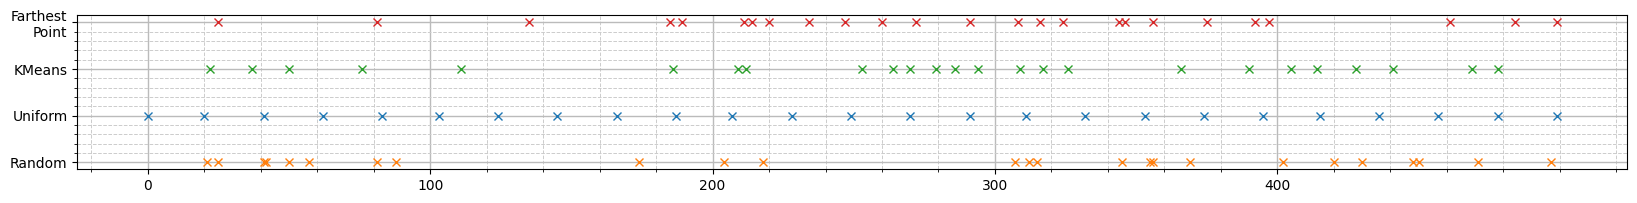

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(uniform_N_samples, np.zeros_like(uniform_N_samples), marker='x', label='Uniform Sampling', linestyle='')
plt.plot(random_N_samples, np.ones_like(random_N_samples)*-1, marker='x', label='Random Sampling', linestyle='')
plt.plot(best_indices_kmeans, np.ones_like(random_N_samples)*1, marker='x', label='KMeans Sampling', linestyle='')
plt.plot(best_indices_farthest_point, np.ones_like(random_N_samples)*2, marker='x', label='Farthest Point Sampling', linestyle='')

plt.yticks([-1,0,1,2],['Random','Uniform','KMeans','Farthest\nPoint'])
# plt.legend()
# plt.minorticks_on()
plt.xticks(np.arange(0,len(valid_files),100))
plt.minorticks_on()
plt.grid(which='major', color='#BBBBBB', linestyle='-', linewidth=1)
plt.grid(which='minor', color='#CCCCCC', linestyle='--', linewidth=0.7)
plt.show()

## Ground Truth Camera Positions

In [ ]:
gt = pd.read_csv(GROUNDTRUTH_PATH, sep=" ")
gt = gt.to_numpy()

NameError: name 'GROUNDTRUTH_PATH' is not defined

In [ ]:
gt_data = torch.tensor(gt[:MAX_IMAGE_FILES,1:8])

In [ ]:
uniform_data = gt_data[uniform_N_samples]
random_data = gt_data[random_N_samples]
kmeans_data = gt_data[best_indices_kmeans]
farthest_data = gt_data[best_indices_farthest_point]

In [ ]:
def rotation_matrix_to_quaternion(R):
    """
    Convert a batch of 3x3 rotation matrices to quaternions.
    R: (..., 3, 3)
    Returns quaternion (..., 4) in (qx, qy, qz, qw) format.
    """
    # Based on Shoemake’s conversion
    qw = torch.sqrt(1.0 + R[...,0,0] + R[...,1,1] + R[...,2,2] + 1e-8) / 2
    qx = (R[...,2,1] - R[...,1,2]) / (4*qw)
    qy = (R[...,0,2] - R[...,2,0]) / (4*qw)
    qz = (R[...,1,0] - R[...,0,1]) / (4*qw)

    q = torch.stack([qx, qy, qz, qw], dim=-1)
    return F.normalize(q, dim=-1)   # normalize quaternion

def extrinsic_to_pose_parameters(extrinsic):
    """
    extrinsic: (1, 5, 3, 4)
    Returns (5, 7) as [tx, ty, tz, qx, qy, qz, qw]
    """
    # Remove the batch dimension → (5, 3, 4)
    extrinsic = extrinsic.squeeze(0)

    R = extrinsic[..., :3]      # (5, 3, 3)
    t = extrinsic[..., 3]       # (5, 3)

    q = rotation_matrix_to_quaternion(R)  # (5, 4)

    # concatenate translation and quaternion
    pose = torch.cat([t, q], dim=-1)  # (5, 7)
    return pose

def quat_to_rotmat(q):
    """
    q = (...,4) in (qx, qy, qz, qw) format
    """
    qx, qy, qz, qw = q.unbind(-1)

    # Elements
    xx = qx*qx; yy = qy*qy; zz = qz*qz
    xy = qx*qy; xz = qx*qz; yz = qy*qz
    wx = qw*qx; wy = qw*qy; wz = qw*qz

    R = torch.stack([
        1 - 2*(yy + zz),  2*(xy - wz),      2*(xz + wy),
        2*(xy + wz),      1 - 2*(xx + zz),  2*(yz - wx),
        2*(xz - wy),      2*(yz + wx),      1 - 2*(xx + yy),
    ], dim=-1).reshape(q.shape[:-1] + (3,3))

    return R

def poses_to_matrices(poses):
    """
    poses: (N,7)
    returns (N,3,4) extrinsics
    """
    t = poses[:, :3]
    q = poses[:, 3:]
    R = quat_to_rotmat(q)
    return torch.cat([R, t.unsqueeze(-1)], dim=-1)

def umeyama_alignment(X, Y):
    """
    X: (N,3) points from traj A
    Y: (N,3) points from traj B
    Solves for similarity transform Y = s R X + t
    Returns s, R, t
    """
    assert X.shape == Y.shape

    mu_X = X.mean(0)
    mu_Y = Y.mean(0)

    Xc = X - mu_X
    Yc = Y - mu_Y

    C = Xc.t() @ Yc / X.shape[0]

    U, D, Vt = torch.linalg.svd(C)
    R = Vt.t() @ U.t()

    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.t() @ U.t()

    var_X = (Xc**2).sum() / X.shape[0]
    s = (D.sum() / var_X)

    t = mu_Y - s * (R @ mu_X)

    return s, R, t
def camera_centers(extr):
    R = extr[:, :3, :3]
    t = extr[:, :3, 3]
    C = -(R.transpose(1,2) @ t.unsqueeze(-1)).squeeze(-1)
    return C
def apply_alignment(s, R, t, centers):
    return (s * (centers @ R.t())) + t
def ate_rmse(A_aligned, B):
    return torch.norm(A_aligned - B, dim=1).mean().sqrt()
def trajectory_similarity(A_ext, B_ext):
    # # 1. Convert to extrinsic matrices
    # A_ext = poses_to_matrices(A_poses)
    # B_ext = poses_to_matrices(B_poses)

    # 2. Compute camera centers
    A_centers = camera_centers(A_ext)
    B_centers = camera_centers(B_ext)

    # 3. Similarity alignment
    s, R, t = umeyama_alignment(A_centers, B_centers)

    # 4. Apply alignment
    A_aligned = apply_alignment(s, R, t, A_centers)

    # 5. Compute errors
    ate = torch.norm(A_aligned - B_centers, dim=1).mean()

    return {
        "scale": s,
        "rotation_alignment": R,
        "translation_alignment": t,
        "ATE": ate.item(),
        "A_centers": A_aligned,
        "B_centers": B_centers
    }


In [ ]:
gt_extrinsic = poses_to_matrices(gt_data)
uniform_extrinsic = poses_to_matrices(uniform_data)
random_extrinsic = poses_to_matrices(random_data)
kmeans_extrinsic = poses_to_matrices(kmeans_data)
farthest_extrinsic = poses_to_matrices(farthest_data)

In [ ]:
gt_camera_centers = camera_centers(gt_extrinsic)
uniform_camera_centers = camera_centers(uniform_extrinsic)
random_camera_centers = camera_centers(random_extrinsic)
kmeans_camera_centers = camera_centers(kmeans_extrinsic)
farthest_camera_centers = camera_centers(farthest_extrinsic)

In [ ]:
gt_camera_centers.shape

torch.Size([500, 3])

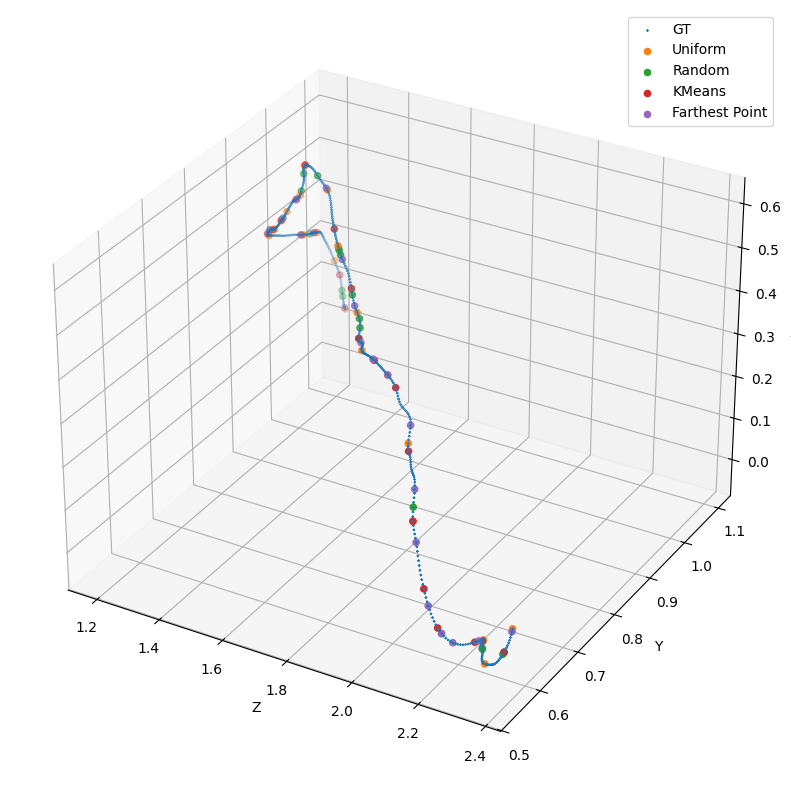

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gt_camera_centers[:,2], gt_camera_centers[:,1], gt_camera_centers[:,0],
           marker='x', s=1, label='GT')
ax.scatter(uniform_camera_centers[:,2], uniform_camera_centers[:,1], uniform_camera_centers[:,0],
           marker='o', s=20, label='Uniform')
ax.scatter(random_camera_centers[:,2], random_camera_centers[:,1], random_camera_centers[:,0],
           marker='o', s=20, label='Random')
ax.scatter(kmeans_camera_centers[:,2], kmeans_camera_centers[:,1], kmeans_camera_centers[:,0],
           marker='o', s=20, label='KMeans')
ax.scatter(farthest_camera_centers[:,2], farthest_camera_centers[:,1], farthest_camera_centers[:,0],
           marker='o', s=20, label='Farthest Point')

ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
ax.legend()

plt.show()


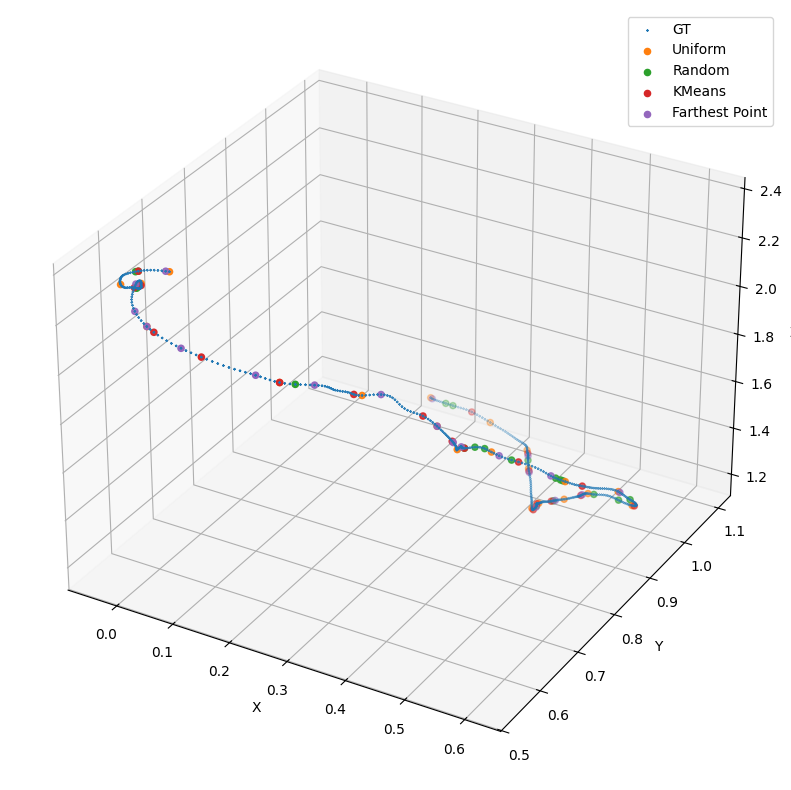

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Ground truth
ax.scatter(
    gt_camera_centers[:,0],  # x
    gt_camera_centers[:,1],  # y
    gt_camera_centers[:,2],  # z
    marker='x', s=1, label='GT'
)

# Uniform
ax.scatter(
    uniform_camera_centers[:,0],
    uniform_camera_centers[:,1],
    uniform_camera_centers[:,2],
    marker='o', s=20, label='Uniform'
)

# Random
ax.scatter(
    random_camera_centers[:,0],
    random_camera_centers[:,1],
    random_camera_centers[:,2],
    marker='o', s=20, label='Random'
)

# KMeans
ax.scatter(
    kmeans_camera_centers[:,0],
    kmeans_camera_centers[:,1],
    kmeans_camera_centers[:,2],
    marker='o', s=20, label='KMeans'
)

# Farthest Point
ax.scatter(
    farthest_camera_centers[:,0],
    farthest_camera_centers[:,1],
    farthest_camera_centers[:,2],
    marker='o', s=20, label='Farthest Point'
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.legend()
plt.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Ground truth
fig.add_trace(go.Scatter3d(
    x=gt_camera_centers[:,0],
    y=gt_camera_centers[:,1],
    z=gt_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='circle'),
    name='GT'
))

# Uniform
fig.add_trace(go.Scatter3d(
    x=uniform_camera_centers[:,0],
    y=uniform_camera_centers[:,1],
    z=uniform_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='Uniform'
))

# Random
fig.add_trace(go.Scatter3d(
    x=random_camera_centers[:,0],
    y=random_camera_centers[:,1],
    z=random_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='Random'
))

# KMeans
fig.add_trace(go.Scatter3d(
    x=kmeans_camera_centers[:,0],
    y=kmeans_camera_centers[:,1],
    z=kmeans_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='KMeans'
))

# Farthest Point
fig.add_trace(go.Scatter3d(
    x=farthest_camera_centers[:,0],
    y=farthest_camera_centers[:,1],
    z=farthest_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='Farthest Point'
))

fig.update_layout(
    width=800,
    height=800,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()


## Ground Truth Point Cloud

In [ ]:
gt_point_cloud_id_map = {}
with open(POINTS_PATH, 'r') as pt_file:
  lines = pt_file.readlines()[3:]
  # lines = [l.split(' ')[1:4] for l in lines]
  for l in lines:
    gt_point_cloud_id_map[l.strip().split(' ')[0]] = l.strip().split(' ')[1:4]
gt_point_cloud_id_map

{'146997': ['2.78156', '3.07207', '-1.49259'],
 '146996': ['10.7942', '20.6576', '16.2148'],
 '146994': ['11.8082', '-1.12076', '5.78683'],
 '146993': ['17.5415', '-10.0758', '6.90205'],
 '146991': ['10.2812', '18.5521', '16.6725'],
 '146990': ['7.8124', '-0.883864', '1.29143'],
 '146989': ['11.1421', '3.35913', '2.45808'],
 '146988': ['9.66964', '9.52035', '5.61158'],
 '146987': ['12.3064', '14.2786', '12.6248'],
 '146986': ['12.328', '15.904', '4.30612'],
 '146985': ['10.0788', '8.75989', '11.0683'],
 '146979': ['17.535', '-9.84891', '4.91526'],
 '146978': ['3.81506', '1.36691', '-1.18851'],
 '146977': ['18.2425', '-13.0431', '14.7419'],
 '146973': ['10.695', '20.4719', '16.1462'],
 '146972': ['11.9984', '-1.90621', '14.9737'],
 '146970': ['9.85367', '4.15061', '6.66107'],
 '146967': ['17.5752', '-10.4216', '14.4548'],
 '146966': ['17.5852', '-10.4652', '14.4755'],
 '146965': ['11.336', '1.35714', '13.0364'],
 '146964': ['10.237', '6.67628', '2.9651'],
 '146963': ['11.8432', '-1.2580

In [ ]:
with open(POINTS_PATH, 'r') as pt_file:
  lines = pt_file.readlines()[3:]
  lines = [[l.strip().split(' ')[0]]+l.strip().split(' ')[8::2] for l in lines]
  print(lines[::-1])


[['62227', '24', '54', '55', '56', '64', '65', '21', '62'], ['62215', '22', '64', '57', '21', '65'], ['62214', '65', '66'], ['62210', '23', '24', '25'], ['62209', '22', '21'], ['62208', '31', '32', '33', '21'], ['62207', '24', '30'], ['62206', '31', '32', '33', '34', '21'], ['62205', '23', '24', '26', '27', '31', '32', '33', '34', '35', '57', '65', '67', '21', '28', '30', '57'], ['62204', '29', '32'], ['62203', '23', '30', '31', '33', '35', '63', '66', '21', '57'], ['62202', '28', '29', '34', '21', '25'], ['62198', '23', '21'], ['62197', '22', '21'], ['62196', '23', '25'], ['62194', '22', '21', '23'], ['62193', '22', '23', '21'], ['62192', '22', '21'], ['62189', '22', '21', '23'], ['62187', '22', '21', '23'], ['62182', '22', '64', '65', '21', '60', '26', '27', '28', '70'], ['62170', '64', '21'], ['62166', '55', '64', '57', '21'], ['62165', '58', '64', '21', '57'], ['62164', '22', '21', '65'], ['62163', '22', '23', '21'], ['62162', '22', '21'], ['62160', '22', '30', '21'], ['62156', '29

In [ ]:
with open(IMAGES_LIST_FILE,'r') as f:
  table = f.readlines()[4:]
  print(table[:10])
  table1 = [[l.split(' ')[0], l.split(' ')[-1].strip().split('/')[-1]] for l in table[::2]]
  ids3d = [set(l.strip().split(' ')[2::3]) for l in table[1::2]]
  print(table1[:10])
  print(ids3d[:10])
  image_id_map = np.array(table1)#,dtype=np.float64)

image_3d_pnt_map = {}
for i in range(len(table1)):
  id = table1[i][0]
  id_list_3d = ids3d[i]
  image_3d_pnt_map[id] = id_list_3d


id_f_map = {}
f_id_map = {}
for id, f in image_id_map:
  if not id in id_f_map:
    id_f_map[id] = [f]
  else:
    id_f_map[id].append(f)
  if not f in f_id_map:
    f_id_map[f] = [id]
  else:
    f_id_map[f].append(id)


['46 0.798535 0.601218 0.0288283 0.00690317 1.19124 -3.16621 -11.0242 0 dslr_images/DSC_0388.JPG\n', '44.9799 6.43974 -1 43.4604 51.6436 -1 43.4604 51.6436 -1 85.4449 28.8626 -1 70.4471 95.49 -1 78.5026 119.067 -1 78.5026 119.067 -1 148.648 36.0584 -1 167.332 58.9005 -1 181.258 56.7781 -1 235.266 12.6089 -1 235.266 12.6089 -1 137.477 76.3317 -1 180.757 106.307 -1 205.701 110.554 -1 238.22 107.394 -1 238.22 107.394 -1 245.485 30.0799 -1 355.479 26.6962 -1 345.389 48.0498 -1 262.961 96.5326 -1 317.166 78.9715 -1 370.284 41.4569 -1 370.284 41.4569 -1 468.35 29.6106 -1 406.254 90.8598 -1 396.501 115.979 -1 432.878 80.1028 -1 437.658 119.626 -1 516.787 14.318 -1 516.787 14.318 -1 4923.58 33.9598 134202 4942.43 55.0226 -1 5024.38 52.857 12064 5194.77 11.787 -1 5118.28 118.878 21600 5168.21 91.7594 -1 5184.92 95.0871 -1 5229.67 24.9135 -1 5311.61 12.1857 -1 5320.72 19.754 -1 5288.55 100.19 100221 5343.93 20.4204 -1 5382.48 45.854 21638 5401.91 25.4386 -1 5727.48 103.187 -1 33.9232 127.668 -1 

In [ ]:
with open(IMAGES_LIST_FILE,'r') as f:
  table = f.readlines()[4:]
  table1 = [l.strip().split(' ') for l in table[::2]]
  image_ids_list = [l[0] for l in table1]
  table2 = [l.strip().split(' ') for l in table[1::2]]
  blocked_pixels = [[(l[3*i],l[3*i+1]) for i in range(len(l)//3)] for l in table2]
  # ids3d = [set(l.strip().split(' ')[2::3]) for l in table[1::2]]
  print(table1[:10])
  # for l in table2:
  #   print(len(l)%3)
  print(blocked_pixels[:10])


[['46', '0.798535', '0.601218', '0.0288283', '0.00690317', '1.19124', '-3.16621', '-11.0242', '0', 'dslr_images/DSC_0388.JPG'], ['45', '0.781067', '0.567757', '0.180839', '-0.18677', '-3.55618', '-3.40206', '-10.0138', '2', 'dslr_images/DSC_0387.JPG'], ['44', '0.661688', '0.47304', '0.367679', '-0.450794', '-8.70563', '-2.20011', '-5.17669', '3', 'dslr_images/DSC_0386.JPG'], ['43', '0.556627', '0.411991', '0.440236', '-0.571508', '14.3013', '0.160328', '0.0218954', '4', 'dslr_images/DSC_0366.JPG'], ['42', '0.457921', '0.336357', '0.495973', '-0.656645', '14.4671', '-1.13316', '-4.08496', '2', 'dslr_images/DSC_0365.JPG'], ['41', '0.334541', '0.239546', '0.546376', '-0.729502', '12.8291', '-2.46026', '-8.59933', '0', 'dslr_images/DSC_0364.JPG'], ['40', '-0.0900492', '-0.0642866', '-0.59362', '0.797103', '6.02249', '-4.22766', '-13.9741', '2', 'dslr_images/DSC_0363.JPG'], ['39', '0.0683523', '0.0565594', '-0.586602', '0.805002', '0.897551', '-4.811', '-14.8743', '2', 'dslr_images/DSC_0362

In [ ]:
# temp = np.array(blocked_pixels[100],dtype=np.float64)*518/6048
# temp = np.array(temp, dtype=np.int16)
# x,y = temp.T
# plt.scatter(x,y)


In [ ]:
image_file_names = [f.strip().split('/')[-1] for f in image_files]
image_file_ids = [f_id_map[f][0] for f in image_file_names]
# image_file_ids == [str(i) for i in range(1, 111)]
file_wise_3d_points = [image_3d_pnt_map[i] for i in image_file_ids]

In [ ]:
file_wise_point_cloud = []
file_wise_untriangulated_points = []
for id3d_list in file_wise_3d_points:
  l = np.array([gt_point_cloud_id_map[id] for id in id3d_list if id != '-1'], dtype=np.float64)
  file_wise_point_cloud.append(l)
for id3d_list in file_wise_3d_points:
  l = np.array([gt_point_cloud_id_map[id] for id in id3d_list if id != '-1'], dtype=np.float64)
  file_wise_point_cloud.append(l)

In [ ]:
gt_uniform_pt_cloud = [file_wise_point_cloud[f] for f in uniform_N_samples]
gt_random_pt_cloud = [file_wise_point_cloud[f] for f in random_N_samples]
gt_kmeans_pt_cloud = [file_wise_point_cloud[f] for f in best_indices_kmeans]
gt_farthest_pt_cloud = [file_wise_point_cloud[f] for f in best_indices_farthest_point]


## VGGT Predictions

In [ ]:
uniform_N_samples, random_N_samples, best_indices_kmeans, best_indices_farthest_point

(array([  0,  20,  41,  62,  83, 103, 124, 145, 166, 187, 207, 228, 249,
        270, 291, 311, 332, 353, 374, 395, 415, 436, 457, 478, 499]),
 array([450,  81, 430, 402, 307,  88, 497,  42, 312, 315, 218,  41, 345,
         50, 448,  57,  25, 369,  21, 204, 356, 355, 174, 420, 471]),
 array([ 22,  37,  50,  76, 111, 186, 209, 212, 253, 264, 270, 279, 286,
        294, 309, 317, 326, 366, 390, 405, 414, 428, 441, 469, 478]),
 array([ 25,  81, 135, 185, 189, 211, 214, 220, 234, 247, 260, 272, 291,
        308, 316, 324, 344, 346, 356, 375, 392, 397, 461, 484, 499]))

In [ ]:
import os
image_dir = IMAGES_PATH
image_list_dir = np.array(os.listdir(image_dir))
image_list_dir.sort()
all_image_paths = [os.path.join(image_dir, f) for f in image_list_dir]
uniform_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[uniform_N_samples]]
random_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[random_N_samples]]
kmeans_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[best_indices_kmeans]]
farthest_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[best_indices_farthest_point]]

In [ ]:
# num_images = 30
# image_names = [os.path.join(image_dir, f) for f in image_list_dir[:num_images]]
# images = load_and_preprocess_images(image_names).to(device)

uniform_sample_images = load_and_preprocess_images(uniform_sample_paths).to(device)
random_sample_images = load_and_preprocess_images(random_sample_paths).to(device)
kmeans_sample_images = load_and_preprocess_images(kmeans_sample_paths).to(device)
farthest_sample_images = load_and_preprocess_images(farthest_sample_paths).to(device)


In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions_uniform = model(uniform_sample_images)
        gc.collect()
        torch.cuda.empty_cache()
        predictions_random = model(random_sample_images)
        gc.collect()
        torch.cuda.empty_cache()
        predictions_kmeans = model(kmeans_sample_images)
        gc.collect()
        torch.cuda.empty_cache()
        predictions_farthest = model(farthest_sample_images)
        gc.collect()
        torch.cuda.empty_cache()


### Camera Trajectory Evaluation

In [ ]:
vggt_uniform_extrinsic, _ = pose_encoding_to_extri_intri(predictions_uniform['pose_enc'], uniform_sample_images.shape[-2:])
vggt_uniform_extrinsic_cpu = vggt_uniform_extrinsic.squeeze(0).to('cpu').float()
vggt_random_extrinsic, _ = pose_encoding_to_extri_intri(predictions_random['pose_enc'], random_sample_images.shape[-2:])
vggt_random_extrinsic_cpu = vggt_random_extrinsic.squeeze(0).to('cpu').float()
vggt_kmeans_extrinsic, _ = pose_encoding_to_extri_intri(predictions_kmeans['pose_enc'], kmeans_sample_images.shape[-2:])
vggt_kmeans_extrinsic_cpu = vggt_kmeans_extrinsic.squeeze(0).to('cpu').float()
vggt_farthest_extrinsic, _ = pose_encoding_to_extri_intri(predictions_farthest['pose_enc'], farthest_sample_images.shape[-2:])
vggt_farthest_extrinsic_cpu = vggt_farthest_extrinsic.squeeze(0).to('cpu').float()


In [ ]:
# extrinsic_cpu = extrinsic.squeeze(0).to('cpu').float()
uniform_comparision = trajectory_similarity(uniform_extrinsic.float(), vggt_uniform_extrinsic_cpu)
random_comparision = trajectory_similarity(random_extrinsic.float(), vggt_random_extrinsic_cpu)
kmeans_comparision = trajectory_similarity(kmeans_extrinsic.float(), vggt_kmeans_extrinsic_cpu)
farthest_comparision = trajectory_similarity(farthest_extrinsic.float(), vggt_farthest_extrinsic_cpu)

In [ ]:
uniform_comparision['ATE'], random_comparision['ATE'], kmeans_comparision['ATE'], farthest_comparision['ATE']

(0.25171685218811035,
 0.31000977754592896,
 0.2712845802307129,
 0.2206999510526657)

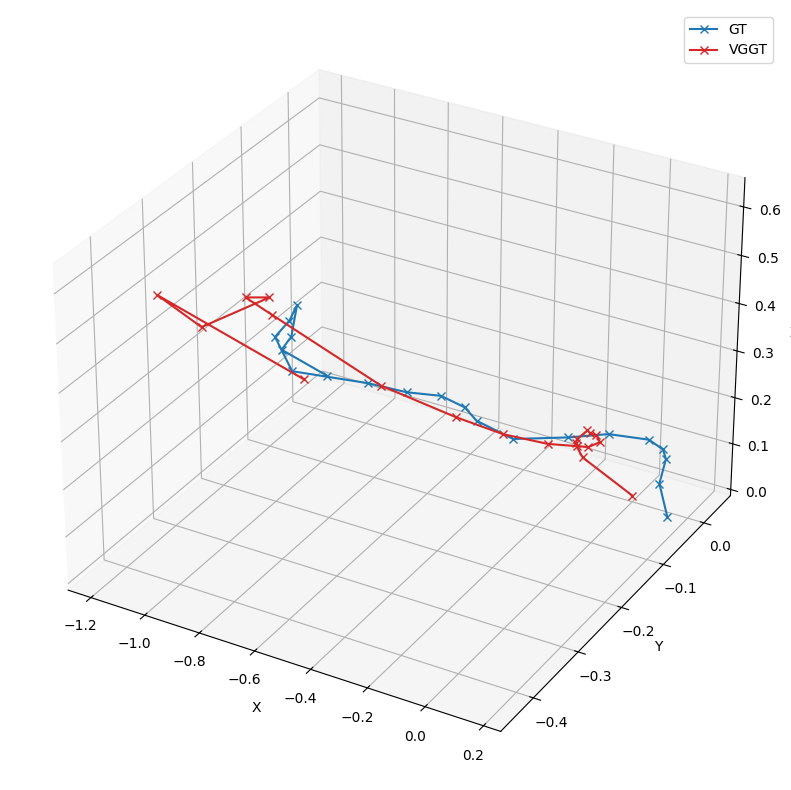

In [ ]:
gt_centers = farthest_comparision['A_centers']
vggt_centers = farthest_comparision['B_centers']
gt_ext = farthest_extrinsic.float()
vggt_ext_cpu = vggt_farthest_extrinsic_cpu

# ======================================================
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# GT trajectory
ax.plot(
    gt_centers[:,0],   # X
    gt_centers[:,1],   # Y
    gt_centers[:,2],   # Z  <-- added for 3D
    marker='x',
    linestyle='-',
    color='tab:blue',
    label='GT'
)

# VGGT trajectory
ax.plot(
    vggt_centers[:,0],  # X
    vggt_centers[:,1],  # Y
    vggt_centers[:,2],  # Z
    marker='x',
    linestyle='-',
    color='tab:red',
    label='VGGT'
)

skip = trajectory_similarity(gt_ext, vggt_ext_cpu)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.legend()
ax.grid(True)

plt.show()


### Point Cloud Evaluation

In [ ]:
torch.save(uniform_sample_images, '/content/exports/uniform_sample_images.pt')
torch.save(random_sample_images, '/content/exports/random_sample_images.pt')
torch.save(kmeans_sample_images, '/content/exports/kmeans_sample_images.pt')
torch.save(farthest_sample_images, '/content/exports/farthest_sample_images.pt')


In [ ]:
vggt_uniform_pt_cloud = predictions_uniform['world_points']
torch.save(vggt_uniform_pt_cloud, '/content/exports/vggt_uniform_pt_cloud.pt')
vggt_random_pt_cloud = predictions_random['world_points']
torch.save(vggt_random_pt_cloud, '/content/exports/vggt_random_pt_cloud.pt')
vggt_kmeans_pt_cloud = predictions_kmeans['world_points']
torch.save(vggt_kmeans_pt_cloud, '/content/exports/vggt_kmeans_pt_cloud.pt')
vggt_farthest_pt_cloud = predictions_farthest['world_points']
torch.save(vggt_farthest_pt_cloud, '/content/exports/vggt_farthest_pt_cloud.pt')

uniform_sample_images.shape

torch.Size([25, 3, 322, 518])

In [ ]:
!zip -r /content/exports.zip /content/exports

updating: content/exports/ (stored 0%)
updating: content/exports/random_sample_images.pt (deflated 82%)
updating: content/exports/vggt_random_pt_cloud.pt (deflated 9%)
updating: content/exports/kmeans_sample_images.pt (deflated 83%)
updating: content/exports/uniform_sample_images.pt (deflated 83%)
updating: content/exports/farthest_sample_images.pt (deflated 83%)
updating: content/exports/vggt_kmeans_pt_cloud.pt

In [ ]:
from google.colab import files
files.download('/content/exports.zip')

In [ ]:
vggt_uniform_pt_cloud = predictions_uniform['world_points'].squeeze().reshape(-1,3)
vggt_random_pt_cloud = predictions_random['world_points'].squeeze().reshape(-1,3)
vggt_kmeans_pt_cloud = predictions_kmeans['world_points'].squeeze().reshape(-1,3)
vggt_farthest_pt_cloud = predictions_farthest['world_points'].squeeze().reshape(-1,3)

In [ ]:
# vggt_uniform_pt_cloud_list = [vggt_uniform_pt_cloud[f].reshape(-1,3) for f in range(vggt_uniform_pt_cloud.shape[0])]
# vggt_random_pt_cloud_list = [vggt_random_pt_cloud[f].reshape(-1,3) for f in range(vggt_random_pt_cloud.shape[0])]
# vggt_kmeans_pt_cloud_list = [vggt_kmeans_pt_cloud[f].reshape(-1,3) for f in range(vggt_kmeans_pt_cloud.shape[0])]
# vggt_farthest_pt_cloud_list = [vggt_farthest_pt_cloud[f].reshape(-1,3) for f in range(vggt_farthest_pt_cloud.shape[0])]

In [ ]:
# Ranges
x = np.arange(0, 350)   # 0 → 350
y = np.arange(0, 518)   # 0 → 518

# Create grid of coordinates
xx, yy = np.meshgrid(x, y)

# Stack into (N, 2) array of coordinate pairs
coords = np.column_stack([xx.ravel(), yy.ravel()])
coords_view = coords.view([('x', coords.dtype), ('y', coords.dtype)])
print(coords.shape)  # (351*519, 2) = (182,169, 2)
print(coords)

(181300, 2)
[[  0   0]
 [  1   0]
 [  2   0]
 ...
 [347 517]
 [348 517]
 [349 517]]


In [ ]:
gt_uniform_pt_cloud_concat = torch.concatenate([torch.tensor(f) for f in gt_uniform_pt_cloud],dim=0)
gt_random_pt_cloud_concat = torch.concatenate([torch.tensor(f) for f in gt_random_pt_cloud],dim=0)
gt_kmeans_pt_cloud_concat = torch.concatenate([torch.tensor(f) for f in gt_farthest_pt_cloud],dim=0)
gt_farthest_pt_cloud_concat = torch.concatenate([torch.tensor(f) for f in gt_farthest_pt_cloud],dim=0)

In [ ]:
gt_random_pt_cloud_concat.shape, vggt_uniform_pt_cloud.shape

(torch.Size([59693, 3]), torch.Size([1813000, 3]))

In [ ]:
import numpy as np
import torch
import faiss # Used for GPU-accelerated Nearest Neighbor Search
import re
import pandas as pd
from scipy.spatial import KDTree



# --- DEVICE CONFIGURATION ---
# Check for CUDA and set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- UMEYAMA ALIGNMENT IMPLEMENTATION (PyTorch/GPU) ---

def umeyama_alignment_gpu(source: torch.Tensor, target: torch.Tensor):
    """
    Finds a similarity matrix (R, t, s) to map source (P) to target (G) using Umeyama algorithm.
    All computations are performed on the specified device (GPU).

    Args:
        source (torch.Tensor): The source points (N, 3).
        target (torch.Tensor): The target points (N, 3).

    Returns:
        torch.Tensor: The 4x4 similarity transformation matrix (T).
        float: The optimal scaling factor (s).
    """

    # Ensure tensors are float32 for faster GPU processing
    source, target = source.float(), target.float()

    # 1. Calculate centroids
    centroid_source = torch.mean(source, dim=0)
    centroid_target = torch.mean(target, dim=0)
    source_centered = source - centroid_source
    target_centered = target - centroid_target

    # 2. Covariance matrix H
    H = source_centered.T @ target_centered

    # 3. Perform SVD using PyTorch's GPU implementation
    U, S, V_t = torch.linalg.svd(H)
    V = V_t.T

    # 4. Calculate rotation matrix R
    d = torch.det(V @ U.T)
    D = torch.diag(torch.tensor([1.0, 1.0, d.sign().item()], device=DEVICE))
    R = V @ D @ U.T

    # 5. Calculate scaling factor s
    scale_numerator = torch.trace(H.T @ R)
    scale_denominator = torch.sum(source_centered ** 2)
    s = scale_numerator / scale_denominator

    # 6. Calculate translation vector t
    t = centroid_target - s * (R @ centroid_source)

    # 7. Construct 4x4 transformation matrix T
    T = torch.eye(4, device=DEVICE)
    T[:3, :3] = s * R
    T[:3, 3] = t

    # Convert scale to a standard float for logging
    return T, s.item()

# --- METRICS CALCULATION (Faiss/GPU) ---

def calculate_chamfer_metrics_gpu(predicted_aligned: torch.Tensor, gt_points: torch.Tensor):
    """
    Calculates Chamfer metrics using FAISS for fast GPU nearest neighbor search.
    """
    # 1. Ensure tensors are float32 for FAISS compatibility
    predicted_aligned, gt_points = predicted_aligned.float(), gt_points.float()

    # 2. Convert PyTorch tensors to flat NumPy arrays for Faiss
    # Faiss requires points to be stored in an index object

    # --- Accuracy (Predicted -> GT: P -> G) ---
    # Index GT points and search with predicted points
    gt_index = faiss.IndexFlatL2(gt_points.shape[1])
    if DEVICE.type == 'cuda':
        res = faiss.StandardGpuResources()
        gt_index = faiss.index_cpu_to_gpu(res, 0, gt_index) # Move index to GPU 0

    gt_index.add(gt_points.cpu().numpy()) # Faiss requires CPU input for construction, then GPU for search

    # D is the distance (L2), I is the index
    D_p_to_g, _ = gt_index.search(predicted_aligned.cpu().numpy(), k=1)
    accuracy = np.mean(np.sqrt(D_p_to_g)) # Faiss returns squared distance (L2)

    # --- Completeness (GT -> Predicted: G -> P) ---
    # Index predicted points and search with GT points
    pred_index = faiss.IndexFlatL2(predicted_aligned.shape[1])
    if DEVICE.type == 'cuda':
        res_pred = faiss.StandardGpuResources()
        pred_index = faiss.index_cpu_to_gpu(res_pred, 0, pred_index)

    pred_index.add(predicted_aligned.cpu().numpy())

    D_g_to_p, _ = pred_index.search(gt_points.cpu().numpy(), k=1)
    completeness = np.mean(np.sqrt(D_g_to_p)) # Faiss returns squared distance (L2)

    # 3. Overall (Chamfer Distance)
    overall_cd = (accuracy + completeness) / 2.0

    return {
        'Accuracy (mm)': accuracy * 1000.0,
        'Completeness (mm)': completeness * 1000.0,
        'Overall_CD (mm)': overall_cd * 1000.0,
    }

# --- MAIN EVALUATION FUNCTION (GPU) ---

def evaluate_point_clouds_gpu(P: torch.Tensor, G: torch.Tensor):
    """
    Main function to filter, align, and evaluate point clouds on the GPU.
    """
    print(f"Starting GPU Evaluation Pipeline on {DEVICE}...")

    # Ensure all inputs are PyTorch Tensors on the correct device
    if isinstance(P, np.ndarray): P = torch.from_numpy(P)
    if isinstance(G, np.ndarray): G = torch.from_numpy(G)
    P, G = P.to(DEVICE).float(), G.to(DEVICE).float()

    # A. PREPARE PREDICTED POINTS (P)

    # Filter invalid points (Crucial Step: Remove sentinel/invalid values)
    print("Filtering predicted points...")
    valid_mask = ~torch.all(P == 0, dim=1)
    P_filtered = P[valid_mask]
    print(f"✅ Predicted points filtered from {P.shape[0]} to {P_filtered.shape[0]}.")

    # B. ESTABLISH CORRESPONDENCES for Umeyama (G -> P)
    print("Finding nearest predicted neighbors for Umeyama alignment (CPU/Faiss setup)...")

    # We use CPU-based KDTree (or Faiss on CPU) for the correspondence setup,
    # as the Umeyama input is smaller and the indices need to be clean.
    p_tree_cpu = KDTree(P_filtered.cpu().numpy())

    # Find the closest predicted point for every GT point
    distances, indices = p_tree_cpu.query(G.cpu().numpy())

    # Create the correspondence tensors on the GPU
    source_for_umeyama = P_filtered[indices]
    target_for_umeyama = G

    # C. PERFORM ALIGNMENT
    print("Performing Umeyama alignment (GPU)...")
    T, s = umeyama_alignment_gpu(source_for_umeyama, target_for_umeyama)

    # Apply transformation to the *entire* filtered predicted cloud (P_filtered)
    homogeneous_predicted = torch.hstack((P_filtered, torch.ones((P_filtered.shape[0], 1), device=DEVICE)))
    aligned_points_homogeneous = T @ homogeneous_predicted.T
    P_aligned = aligned_points_homogeneous[:3, :].T

    print(f"✅ Alignment complete. Scale factor found: {s:.4f}")

    # D. CALCULATE METRICS
    print("Calculating Accuracy, Completeness, and Chamfer Distance (GPU/Faiss)...")
    metrics = calculate_chamfer_metrics_gpu(P_aligned, G)
    metrics['Scale Factor'] = s

    return metrics

# --- RUN THE EVALUATION ---

# Assuming your variables are defined and loaded as NumPy/PyTorch arrays:
# Example dummy initialization (replace with your actual data)
# G_DUMMY_DATA = np.random.rand(34159, 3) * 5
# P_DUMMY_DATA = np.random.rand(1813000, 3) * 10
# P_DUMMY_DATA[::100] = 0.0 # Simulate some invalid points

# gt_uniform_pt_cloud_concat = G_DUMMY_DATA
# vggt_uniform_pt_cloud = P_DUMMY_DATA

# # Run the GPU-accelerated evaluation
# final_results_gpu = evaluate_point_clouds_gpu(vggt_uniform_pt_cloud, gt_uniform_pt_cloud_concat)

# print("\n--- FINAL EVALUATION RESULTS (GPU-Accelerated) ---")
# if final_results_gpu:
#     for k, v in final_results_gpu.items():
#         print(f"**{k}**: {v:.4f}")

Using device: cuda


In [ ]:
final_results = evaluate_point_clouds_gpu(vggt_uniform_pt_cloud, gt_uniform_pt_cloud_concat)

Starting GPU Evaluation Pipeline on cuda...
Filtering predicted points...
✅ Predicted points filtered from 1813000 to 1813000.
Finding nearest predicted neighbors for Umeyama alignment (CPU/Faiss setup)...
Performing Umeyama alignment (GPU)...
✅ Alignment complete. Scale factor found: 8.1386
Calculating Accuracy, Completeness, and Chamfer Distance (GPU/Faiss)...


In [ ]:
final_results

{'Accuracy (mm)': np.float32(2489.623),
 'Completeness (mm)': np.float32(7718.8667),
 'Overall_CD (mm)': np.float32(5104.245),
 'Scale Factor': 8.138587951660156}

In [ ]:
# vggt_uniform_pt_cloud_masked = []
# for i in range(vggt_uniform_pt_cloud.shape[0]):
#   frame_i = uniform_N_samples[i]
#   negative_mask = np.array(np.array(blocked_pixels[frame_i],dtype=np.float64)*518/6048, dtype=np.int16)
#   # print(negative_mask.shape)
#   # print(coords.shape)
#   # Convert to structured arrays so rows are compared as single items
#   negative_mask_view = negative_mask.view([('x', negative_mask.dtype), ('y', negative_mask.dtype)])

#   # Set difference
#   filtered = np.setdiff1d(coords_view, negative_mask_view)

#   # Convert back to normal 2-column array
#   filtered = filtered.view(coords.dtype).reshape(-1, 2)
#   print(filtered.shape[0], coords.shape[0]-negative_mask.shape[0])

#   x,y=negative_mask.T
#   plt.scatter(x,y, s=1)
#   plt.show()


In [ ]:
vggt_uniform_pt_cloud.shape, gt_uniform_pt_cloud_concat.shape

(torch.Size([1813000, 3]), torch.Size([46632, 3]))

In [ ]:
518*350

181300

In [ ]:
import open3d as o3d
import numpy as np

def read_ply_file_colab(filepath):
    """
    Reads a PLY file using Open3D and extracts point and color data.
    """
    try:
        # 1. Read the PLY file into an Open3D PointCloud object
        pcd = o3d.io.read_point_cloud(filepath)

        if pcd.is_empty():
            print(f"❌ Error: The file '{filepath}' is empty or could not be read.")
            return None, None

        # 2. Extract vertices (X, Y, Z) as a NumPy array (N, 3)
        points = np.asarray(pcd.points)

        # 3. Extract colors (R, G, B) if present (Open3D stores normalized [0, 1] colors)
        if pcd.has_colors():
            colors = np.asarray(pcd.colors)
        else:
            colors = None

        print(f"✅ Successfully read {points.shape[0]} points.")
        print(f"Point data shape: {points.shape}")
        if colors is not None:
            print(f"Color data shape: {colors.shape}")

        return points, colors

    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None, None

# IMPORTANT: Change this to your uploaded file name!
FILE_NAME = '/content/Downloads/facade/scan_clean/scan1.ply'

# Load the data
points_data, colors_data = read_ply_file_colab(FILE_NAME)
points_data.shape

✅ Successfully read 14839399 points.
Point data shape: (14839399, 3)
Color data shape: (14839399, 3)


(14839399, 3)

## Quantization


In [ ]:
# === vggt_quantize_full.py ===
import torch, numpy as np, os, math
from copy import deepcopy

# ------------------ CONFIG ------------------
BITS = 8                    # use INT8
MAX_INT = (2**(BITS-1))-1   # 127 for signed int8
SIZE_THRESHOLD = 512        # tensors smaller than this -> keep FP16
OUTLIER_RATIO_THRESH = 50.0 # strong outlier -> keep FP16
VAR_THRESHOLD = 1e-8        # tiny variance -> keep FP16
MEAN_RESIDUAL_VAR_THRESH = 1e-6  # if residual var < this * scale, split mean
APPLY_TO_MODEL = True       # if True, will create a model copy and apply quantized weights
SAVE_QDICT_PATH = "/content/quantized_vggt_qdict.pt"
# --------------------------------------------

def tensor_stats_np(arr):
    """Return basic stats of numpy array arr"""
    a = arr
    mean = float(np.mean(a))
    var = float(np.var(a))
    std = math.sqrt(var) if var>0 else 0.0
    absmax = float(np.max(np.abs(a)))
    medabs = float(np.median(np.abs(a)) + 1e-12)
    outlier_ratio = absmax / medabs if medabs>0 else float('inf')
    size = a.size
    return {"mean":mean, "var":var, "std":std, "absmax":absmax,
            "medabs":medabs, "outlier_ratio":outlier_ratio, "size":size}

def decide_plan_for_param(name, param_np):
    """
    Decide 'fp16' or 'int8' for a parameter by quick heuristics.
    Sensitive names (heads, norm, embed, pos) are FP16.
    Small tensors, huge dyn range, tiny variance, extreme outliers -> FP16.
    Otherwise -> INT8 (subject to mean-split later).
    """
    lname = name.lower()
    stats = tensor_stats_np(param_np)
    # layer-name based exclusions (keep FP16)
    sensitive_keywords = ["patch", "embed", "pos", "position", "norm", "ln", "depth", "pose", "head"]
    if any(k in lname for k in sensitive_keywords):
        return "fp16", stats
    # tensor-stat based rules
    if stats["size"] < SIZE_THRESHOLD:
        return "fp16", stats
    if stats["var"] < VAR_THRESHOLD:
        return "fp16", stats
    if stats["outlier_ratio"] > OUTLIER_RATIO_THRESH:
        return "fp16", stats
    # otherwise safe candidate for INT8
    return "int8", stats

def try_split_mean_residual(param_tensor, per_channel=False, channel_axis=0):
    """
    Try splitting mean + residual.
    - If per_channel and tensor has dim>=2:
        compute mean per channel (over all axes except channel_axis).
      If residual variance (per-channel) is tiny relative to magnitude, keep channel means.
    - Else, compute global mean, and if residual variance tiny, return scalar mean + residual tensor.
    Returns (mean, residual_tensor, mean_kind) where mean_kind is 'none','scalar','per_channel'
    """
    arr = param_tensor.detach().cpu().numpy()
    ndim = arr.ndim
    if per_channel and ndim >= 2:
        # compute mean per channel along channel_axis
        axes = tuple(i for i in range(ndim) if i != channel_axis)
        ch_means = np.mean(arr, axis=axes, keepdims=False)  # shape = (C,)
        # residual per channel
        # broadcast ch_means back to arr shape to compute residual var per channel
        reshape = [1]*ndim
        reshape[channel_axis] = arr.shape[channel_axis]
        chmeans_reshaped = ch_means.reshape(tuple(reshape))
        residual = arr - chmeans_reshaped
        # compute per-channel variance of residual
        ch_var = np.var(residual, axis=axes)
        # decide if per-channel split is useful: residual variances are very small
        # compare ch_var to (mean magnitude)^2 scaled threshold
        mean_mag_sq = np.maximum(ch_means**2, 1e-12)
        # if median ratio of residual var / mean_mag_sq is very small, accept
        ratio_median = np.median(ch_var / mean_mag_sq)
        if ratio_median < MEAN_RESIDUAL_VAR_THRESH:
            # return per-channel mean and residual tensor (as torch)
            return ch_means.astype(np.float32), torch.from_numpy(residual).to(param_tensor.device).type(param_tensor.dtype), "per_channel"
        # else, do not split per-channel; fallthrough to scalar
    # scalar mean check
    arr_flat = arr
    mean = float(np.mean(arr_flat))
    residual = arr_flat - mean
    res_var = float(np.var(residual))
    # Heuristic: if residual variance tiny compared to mean^2 or absolute small
    if res_var < MEAN_RESIDUAL_VAR_THRESH * max(1.0, mean*mean):
        # reshape residual to original shape and return
        return mean, torch.from_numpy((arr - mean)).to(param_tensor.device).type(param_tensor.dtype), "scalar"
    return None, param_tensor, "none"

def per_channel_quantize(residual_tensor, bits=BITS, channel_axis=0):
    """
    Perform symmetric per-channel quantization along channel_axis for residual_tensor (torch).
    Returns q (np.int8 ndarray), scales (np.float32 1D), channel_axis (int)
    """
    arr = residual_tensor.detach().cpu().numpy()
    ndim = arr.ndim
    if ndim < 2:
        # fallback to per-tensor quant
        absmax = float(np.max(np.abs(arr)))
        scale = absmax / MAX_INT if absmax>0 else 1.0
        q = np.round(arr / scale).astype(np.int8)
        return q, np.array([scale], dtype=np.float32), -1
    # compute max per channel over all other axes
    axes = tuple(i for i in range(ndim) if i != channel_axis)
    max_per_channel = np.max(np.abs(arr), axis=axes)
    # avoid zeros
    max_per_channel[max_per_channel==0] = 1.0
    scales = (max_per_channel / MAX_INT).astype(np.float32)  # shape = (C,)
    # broadcast scales to arr shape for quant
    reshape = [1]*ndim
    reshape[channel_axis] = arr.shape[channel_axis]
    scales_r = scales.reshape(tuple(reshape))
    qf = np.round(arr / scales_r)
    qf = np.clip(qf, -MAX_INT, MAX_INT).astype(np.int8)
    return qf, scales

def per_tensor_quantize(residual_tensor, bits=BITS):
    arr = residual_tensor.detach().cpu().numpy()
    absmax = float(np.max(np.abs(arr)))
    scale = absmax / MAX_INT if absmax>0 else 1.0
    q = np.round(arr / scale)
    q = np.clip(q, -MAX_INT, MAX_INT).astype(np.int8)
    return q, float(scale)

# ---------------- main pipeline ----------------
def analyze_and_quantize_model(model,
                               per_channel_for_large=True,
                               channel_axis_default=0,
                               size_threshold=SIZE_THRESHOLD,
                               save_qdict_path=SAVE_QDICT_PATH):
    """
    Analyzes model parameters and returns qdict with quantized data for int8 params and fp16 for others.
    If APPLY_TO_MODEL True, also returns a model copy with dequantized weights applied.
    """
    qdict = {}
    plan = {}
    # 1) Decide plan per param
    for name, param in model.named_parameters():
        if not param.requires_grad:
            # still consider it
            pass
        arr = param.detach().cpu().numpy()
        decision, stats = decide_plan_for_param(name, arr)
        plan[name] = decision

    # 2) For each param assigned int8, attempt mean+residual splitting (per-channel if possible), then quantize residual per-channel
    for name, param in model.named_parameters():
        decision = plan[name]
        tensor = param.data
        info = {"dtype": None}
        if decision == "fp16":
            info["dtype"] = "fp16"
            info["value"] = tensor.detach().cpu().numpy().astype(np.float16)
            info["shape"] = tuple(tensor.shape)
            qdict[name] = info
            continue

        # decision == int8
        # Attempt per-channel mean+residual split first (if dims allow)
        per_channel = per_channel_for_large and (tensor.ndim >= 2)
        mean_val, residual_tensor, mean_kind = try_split_mean_residual(tensor, per_channel=per_channel, channel_axis=channel_axis_default)
        # If mean_kind is per_channel and the residual still qualifies for quantization, we will quantize per-channel residual
        if mean_kind == "per_channel":
            # quantize residual per-channel
            qweight, scales = per_channel_quantize(residual_tensor, bits=BITS, channel_axis=channel_axis_default)
            info["dtype"] = "int8"
            info["qweight"] = qweight  # np.int8 array
            info["scale"] = scales     # np.float32 1D
            info["mean"] = mean_val.astype(np.float32)  # np array per channel
            info["mean_kind"] = "per_channel"
            info["per_channel"] = True
            info["channel_axis"] = channel_axis_default
            info["shape"] = tuple(tensor.shape)
            qdict[name] = info
            continue
        elif mean_kind == "scalar":
            # scalar mean removed, quantize residual; do per-channel quant if tensor large
            if per_channel and tensor.ndim >= 2:
                qweight, scales = per_channel_quantize(residual_tensor, bits=BITS, channel_axis=channel_axis_default)
                info["dtype"] = "int8"
                info["qweight"] = qweight
                info["scale"] = scales
                info["mean"] = float(mean_val)
                info["mean_kind"] = "scalar"
                info["per_channel"] = True
                info["channel_axis"] = channel_axis_default
                info["shape"] = tuple(tensor.shape)
            else:
                qweight, scale = per_tensor_quantize(residual_tensor, bits=BITS)
                info["dtype"] = "int8"
                info["qweight"] = qweight
                info["scale"] = float(scale)
                info["mean"] = float(mean_val)
                info["mean_kind"] = "scalar"
                info["per_channel"] = False
                info["shape"] = tuple(tensor.shape)
            qdict[name] = info
            continue
        else:
            # no mean split; quantize residual_tensor directly (prefer per-channel for >=2D)
            if per_channel and tensor.ndim >= 2:
                qweight, scales = per_channel_quantize(residual_tensor, bits=BITS, channel_axis=channel_axis_default)
                info["dtype"] = "int8"
                info["qweight"] = qweight
                info["scale"] = scales
                info["mean"] = None
                info["mean_kind"] = "none"
                info["per_channel"] = True
                info["channel_axis"] = channel_axis_default
                info["shape"] = tuple(tensor.shape)
            else:
                qweight, scale = per_tensor_quantize(residual_tensor, bits=BITS)
                info["dtype"] = "int8"
                info["qweight"] = qweight
                info["scale"] = float(scale)
                info["mean"] = None
                info["mean_kind"] = "none"
                info["per_channel"] = False
                info["shape"] = tuple(tensor.shape)
            qdict[name] = info
            continue

    # 3) Optionally apply dequantized weights to a model copy for testing
    model_q = None
    if APPLY_TO_MODEL:
        model_q = deepcopy(model)
        # assign
        for name, param in model_q.named_parameters():
            info = qdict.get(name, None)
            if info is None:
                continue
            if info["dtype"] == "fp16":
                arr = info["value"].astype(np.float32)
                param.data = torch.from_numpy(arr).to(param.device).type(torch.float16)
            elif info["dtype"] == "int8":
                if info.get("per_channel", False):
                    q = info["qweight"].astype(np.float32)
                    scales = info["scale"].astype(np.float32) if isinstance(info["scale"], np.ndarray) else np.array([info["scale"]], dtype=np.float32)
                    ch_axis = info.get("channel_axis", 0)
                    # Broadcast scales to array shape
                    shape = info["shape"]
                    reshape = [1]*len(shape)
                    reshape[ch_axis] = scales.shape[0]
                    scales_r = scales.reshape(tuple(reshape))
                    arr = q * scales_r
                else:
                    arr = info["qweight"].astype(np.float32) * float(info["scale"])
                if info.get("mean", None) is not None:
                    meanv = info["mean"]
                    if info.get("mean_kind","") == "per_channel":
                        # mean per channel: broadcast
                        mean_arr = np.array(meanv, dtype=np.float32)
                        reshape = [1]*len(info["shape"])
                        reshape[info.get("channel_axis",0)] = mean_arr.shape[0]
                        mean_r = mean_arr.reshape(tuple(reshape))
                        arr = arr + mean_r
                    else:
                        arr = arr + float(meanv)
                # assign as fp16
                param.data = torch.from_numpy(arr).to(param.device).type(torch.float16)
            else:
                raise RuntimeError("unknown dtype in qdict entry")
    # 4) Save qdict
    torch.save(qdict, save_qdict_path)
    print("Saved quantized dictionary to:", save_qdict_path)
    return qdict, plan, model_q

# ---------------- USAGE ----------------
# Example (after you loaded model):
# qdict, plan, model_q = analyze_and_quantize_model(model)
# model_q is a fp16 model with dequantized weights (if APPLY_TO_MODEL True)
# qdict contains compact int8 arrays + scales + means and can be saved/loaded

# ------------------------------------------------
# If you want to run right away (uncomment), e.g.:
qdict, plan, model_q = analyze_and_quantize_model(model)
print("Done. Example entries:")
for k,v in list(qdict.items())[:8]:
    print(k, "->", v["dtype"], "shape", v["shape"], "per_channel" , v.get("per_channel",False))
# ------------------------------------------------
